### 1. Import libraries

In [1]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

D:\PROJECT_NEURON\Human_Segmentation_Using_Albumentations\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\PROJECT_NEURON\Human_Segmentation_Using_Albumentations\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\PROJECT_NEURON\Human_Segmentation_Using_Albumentations\env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 206] The filename or extension is too long: 'D:\\PROJECT_NEURON\\Human_Segmentation_Using_Albumentations\\env\\lib\\site-packages\\torchvision'
  warn(f"Failed to load image Python extension: {e}")
D:\PROJECT_NEURON\Human_Segmentation_Using_Albumentations\env\

### 2. Check Pytorch Cuda Version

In [2]:
print(torch.__version__)

print(torch.version.cuda)

1.13.1+cu116
11.6
1.13.1+cu116
11.6


### 3. Load Pandas Train CSV File

In [3]:
file_path = './data/train.csv'
df = pd.read_csv(file_path)

### 4. Check top 5 rows of columns

In [4]:
df.head()

,masks,images
0,data/Ground_Truth/1.png,data/Training_Images/1.jpg
1,data/Ground_Truth/10.png,data/Training_Images/10.jpg
2,data/Ground_Truth/100.png,data/Training_Images/100.jpg
3,data/Ground_Truth/101.png,data/Training_Images/101.jpg
4,data/Ground_Truth/102.png,data/Training_Images/102.jpg


,masks,images
0,data/Ground_Truth/1.png,data/Training_Images/1.jpg
1,data/Ground_Truth/10.png,data/Training_Images/10.jpg
2,data/Ground_Truth/100.png,data/Training_Images/100.jpg
3,data/Ground_Truth/101.png,data/Training_Images/101.jpg
4,data/Ground_Truth/102.png,data/Training_Images/102.jpg


### 5. Preparing Masks and Images for Visulaization

In [5]:
row = df.iloc[8]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0

### 6. Visualize Mask and Image

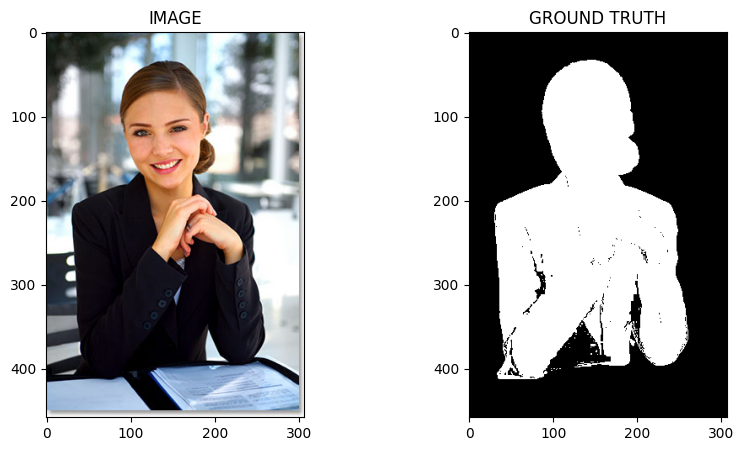

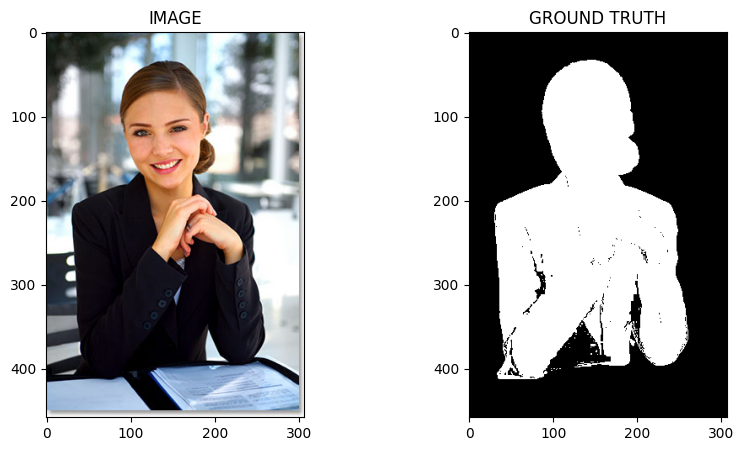

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

### 7. Use Albumentations Library for data augmentation

In [7]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
                    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

- RGBShift = This can be useful for introducing color variations in the training data to make the model more robust to different lighting conditions.

### 8. Prepare Our Custom Data

In [8]:
class CustomData(Dataset):
    def __init__(self,df, augmentations):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks
        
        image = cv2.imread(image_path) # BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # this have 2 dim (h,w)
        # we need add new dim (h, w, c)
        mask = np.expand_dims(mask, axis= -1)
        
        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']
            
        #(h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        
        # convert from np to tensor
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)
        
        return image, mask

- `cv2.COLOR_BGR2RGB` -This conversion is important because many other image processing libraries and applications use the RGB color space as the default, so converting an image from BGR to RGB can make it easier to work with

### 9. Spliting Data into Train and Test

In [9]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
trainset = CustomData(train_df, get_train_augs())
validset = CustomData(valid_df, get_valid_augs())

In [11]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58
Size of Trainset : 232
Size of Validset : 58


### 10. Validating Trainset 

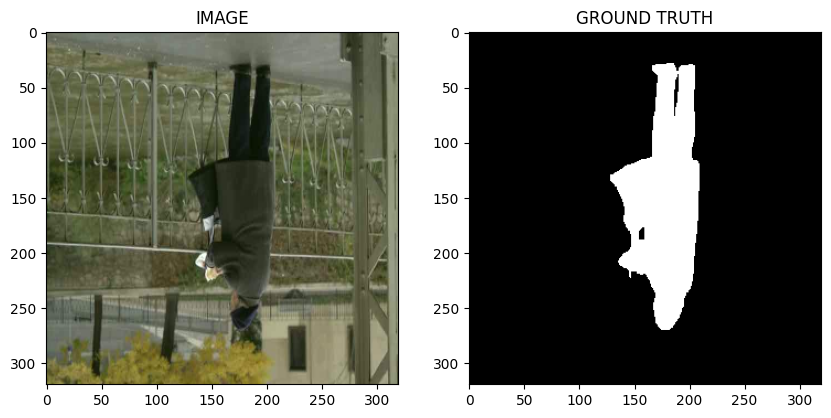

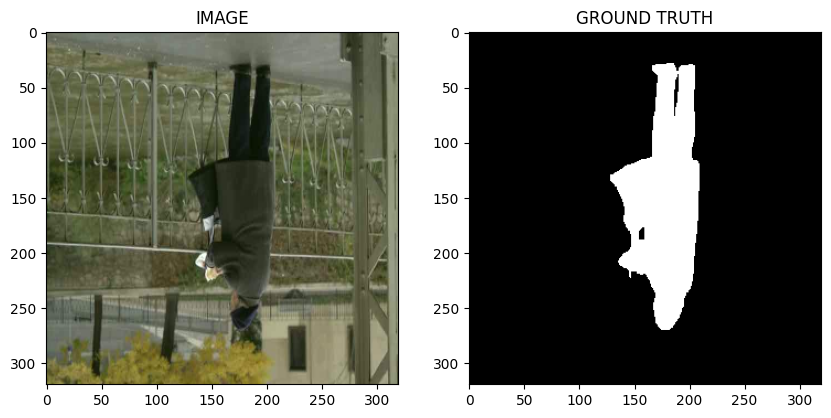

In [12]:
image, mask  = trainset[4]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0),cmap = 'gray')

### 11. Load the dataset folders into a data loader

In [13]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [14]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4
Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [15]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")
# the second value is no. of channel 

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])
One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


### 12. Create Model

In [16]:
ENCODER = 'timm-efficientnet-b0'
WIEGHTS = 'imagenet'

In [17]:
class SegmentationModel(nn.Module):

  def __init__(self):
      super(SegmentationModel, self).__init__()

      self.arc = smp.Unet(
          encoder_name= ENCODER,
          encoder_weights= WIEGHTS,
          in_channels= 3,
          classes= 1,
          activation= None
      )
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode= 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

device(type='cuda')

In [20]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

### 13. Prepare Train Function

In [21]:
def train_function(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

### 14. Prepare Evaluate Function

In [22]:
def eval_function(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

### 15. Define Hyper Parameters

In [24]:
EPOCHS = 25
LR = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

### 16. Train the Model and Save Model

In [25]:
from pandas.core.algorithms import mode
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_function(trainloader, model, optimizer)
  valid_loss = eval_function(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("saved model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:56<00:00,  3.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]



saved model
Epoch : 1 Train_loss : 0.8307551145553589 valid_loss : 0.6004091575741768
saved model
Epoch : 1 Train_loss : 0.8307551145553589 valid_loss : 0.6004091575741768


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]



saved model
Epoch : 2 Train_loss : 0.4692652503649394 valid_loss : 0.5760900303721428
saved model
Epoch : 2 Train_loss : 0.4692652503649394 valid_loss : 0.5760900303721428


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]



saved model
Epoch : 3 Train_loss : 0.43078857064247134 valid_loss : 0.5648745968937874
saved model
Epoch : 3 Train_loss : 0.43078857064247134 valid_loss : 0.5648745968937874


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]



saved model
Epoch : 4 Train_loss : 0.41547351479530337 valid_loss : 0.27284782379865646
saved model
Epoch : 4 Train_loss : 0.41547351479530337 valid_loss : 0.27284782379865646


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]



saved model
Epoch : 5 Train_loss : 0.3716665784517924 valid_loss : 0.23007936775684357
saved model
Epoch : 5 Train_loss : 0.3716665784517924 valid_loss : 0.23007936775684357


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]



Epoch : 6 Train_loss : 0.32108433842658995 valid_loss : 0.2391384020447731
Epoch : 6 Train_loss : 0.32108433842658995 valid_loss : 0.2391384020447731


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]



Epoch : 7 Train_loss : 0.33380313316981 valid_loss : 0.24722136929631233
Epoch : 7 Train_loss : 0.33380313316981 valid_loss : 0.24722136929631233


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]



saved model
Epoch : 8 Train_loss : 0.29982638657093047 valid_loss : 0.2184576392173767
saved model
Epoch : 8 Train_loss : 0.29982638657093047 valid_loss : 0.2184576392173767


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]



Epoch : 9 Train_loss : 0.2759606301784515 valid_loss : 0.22695007175207138


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 9 Train_loss : 0.2759606301784515 valid_loss : 0.22695007175207138


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]



Epoch : 10 Train_loss : 0.2929145614306132 valid_loss : 0.26597927138209343
Epoch : 10 Train_loss : 0.2929145614306132 valid_loss : 0.26597927138209343


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]



Epoch : 11 Train_loss : 0.2829151153564453 valid_loss : 0.2246815375983715
Epoch : 11 Train_loss : 0.2829151153564453 valid_loss : 0.2246815375983715


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]



saved model
Epoch : 12 Train_loss : 0.2658163090546926 valid_loss : 0.20931538566946983
saved model
Epoch : 12 Train_loss : 0.2658163090546926 valid_loss : 0.20931538566946983


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]



Epoch : 13 Train_loss : 0.27223934829235075 valid_loss : 0.21366720646619797
Epoch : 13 Train_loss : 0.27223934829235075 valid_loss : 0.21366720646619797


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]



Epoch : 14 Train_loss : 0.2587667832771937 valid_loss : 0.24275361746549606
Epoch : 14 Train_loss : 0.2587667832771937 valid_loss : 0.24275361746549606


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.47it/s]



Epoch : 15 Train_loss : 0.241474183400472 valid_loss : 0.21536372229456902


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 15 Train_loss : 0.241474183400472 valid_loss : 0.21536372229456902


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]



Epoch : 16 Train_loss : 0.2677388350168864 valid_loss : 0.30600354075431824
Epoch : 16 Train_loss : 0.2677388350168864 valid_loss : 0.30600354075431824


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]



Epoch : 17 Train_loss : 0.2644750783840815 valid_loss : 0.21676497161388397
Epoch : 17 Train_loss : 0.2644750783840815 valid_loss : 0.21676497161388397


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]



saved model
Epoch : 18 Train_loss : 0.22807243963082632 valid_loss : 0.1951661892235279
saved model
Epoch : 18 Train_loss : 0.22807243963082632 valid_loss : 0.1951661892235279


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]



Epoch : 19 Train_loss : 0.2475628266731898 valid_loss : 0.20185983180999756
Epoch : 19 Train_loss : 0.2475628266731898 valid_loss : 0.20185983180999756


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]



Epoch : 20 Train_loss : 0.22991502930720648 valid_loss : 0.2423657774925232
Epoch : 20 Train_loss : 0.22991502930720648 valid_loss : 0.2423657774925232


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.48it/s]



saved model
Epoch : 21 Train_loss : 0.21655210653940837 valid_loss : 0.1476452425122261
saved model
Epoch : 21 Train_loss : 0.21655210653940837 valid_loss : 0.1476452425122261


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]



Epoch : 22 Train_loss : 0.19381880064805349 valid_loss : 0.1618252918124199
Epoch : 22 Train_loss : 0.19381880064805349 valid_loss : 0.1618252918124199


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06it/s]



Epoch : 23 Train_loss : 0.19453564484914143 valid_loss : 0.22009939700365067
Epoch : 23 Train_loss : 0.19453564484914143 valid_loss : 0.22009939700365067


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]



Epoch : 24 Train_loss : 0.19073039740324021 valid_loss : 0.21176709607243538
Epoch : 24 Train_loss : 0.19073039740324021 valid_loss : 0.21176709607243538


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.11it/s]

Epoch : 25 Train_loss : 0.18961760302384695 valid_loss : 0.20590658858418465
Epoch : 25 Train_loss : 0.18961760302384695 valid_loss : 0.20590658858418465


### 17. Perform predictions

In [28]:
idx = 50

model.load_state_dict(torch.load('./best_model.pt'))
image, mask = validset[idx]
#used to add an extra dimension for batch as model takes (batch, channel, height, width)
logits_mask = model(image.to(device).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

- Applies a threshold of 0.5 to the probability mask to convert it to a binary mask. 
- If the probability of a pixel being part of the object is greater than 0.5, it is classified as part of the object and assigned a value of 1.0. Otherwise, it is classified as background and assigned a value of 0.0.

MASK torch.Size([1, 320, 320])
pred_mask torch.Size([1, 1, 320, 320])
MASK torch.Size([1, 320, 320])
pred_mask torch.Size([1, 1, 320, 320])


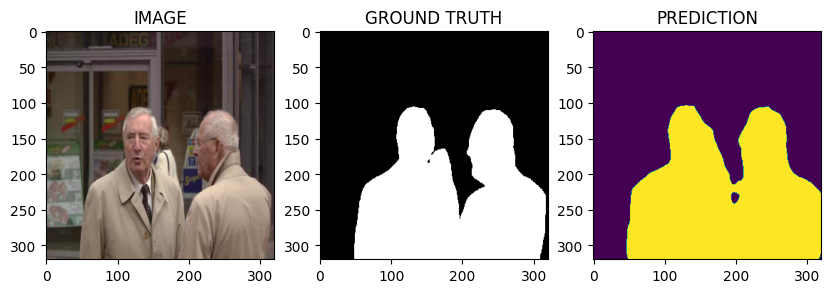

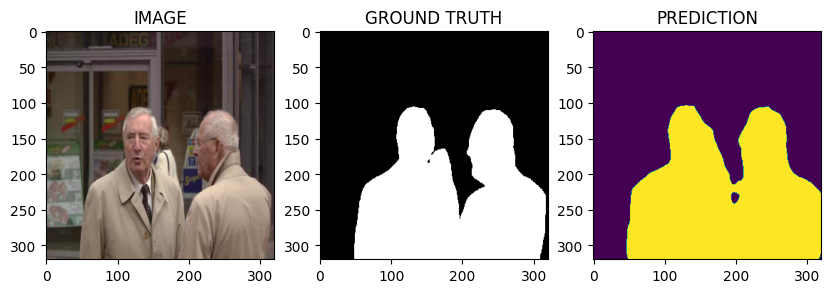

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0),cmap = 'gray')
print("MASK",mask.shape)

ax3.set_title('PREDICTION')
ax3.imshow(pred_mask.detach().cpu().squeeze(0).permute(1,2,0))
print("pred_mask",pred_mask.shape)